In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import FakeVigoV2
from random import randint, random, choice
from qiskit.circuit.library import HGate, SGate, XGate, ZGate
from qiskit.providers.aer import Aer
from experiment import SparsePauliTomographyExperiment as bcexperiment
from primitives.term import QiskitPauli
from analysis import Analysis

backend = FakeVigoV2()

In [2]:
experiment = bcexperiment.load()

In [4]:
analysis = Analysis.load()

UnsupportedOperation: read

In [2]:
def executor(circuits):
    return backend.run(circuits).result().get_counts()

In [3]:
qc = QuantumCircuit(5)
qc.cx(0,1)
qc.cx(3,4)
qc.cx(1,2)
qc.cx(1,3)
qc.draw()

q_0: ──■────────────
     ┌─┴─┐          
q_1: ┤ X ├──■────■──
     └───┘┌─┴─┐  │  
q_2: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_3: ──■───────┤ X ├
     ┌─┴─┐     └───┘
q_4: ┤ X ├──────────
     └───┘

In [4]:
experiment = bcexperiment(qc, [0,1,2,3,4], backend)

In [5]:
experiment.generate(50,50, [2,4,16])

In [7]:
experiment.run(executor)

In [8]:
experiment.save()

In [3]:
experiment.analyze()

In [6]:
experiment.analysis.save()

In [4]:
layers = experiment.analysis.profiles()

<AxesSubplot:>

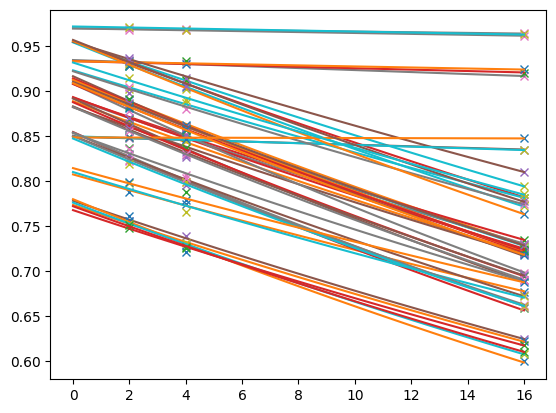

In [5]:
experiment.analysis.plot(layers[1])

In [25]:
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import numpy as np

In [35]:
layers[0].qc.draw()

q_0: ─────
          
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          
q_4: ─────

In [70]:
expec = experiment.analysis._data[layers[0]]._term_data[QiskitPauli("XXIII")]._list_expectations()
depths = experiment.analysis._data[layers[0]]._term_data[QiskitPauli("ZZIII")]._depths()

In [71]:
print(experiment.analysis._data[layers[0]]._term_data[QiskitPauli("ZZIII")].fidelity)

0.9987733293350176


In [72]:
expfit = lambda x,a,b: a*np.exp(-b*x)
popt,_ = curve_fit(expfit, depths, expec)

In [76]:
np.exp(-popt[1])

0.9986636459927113

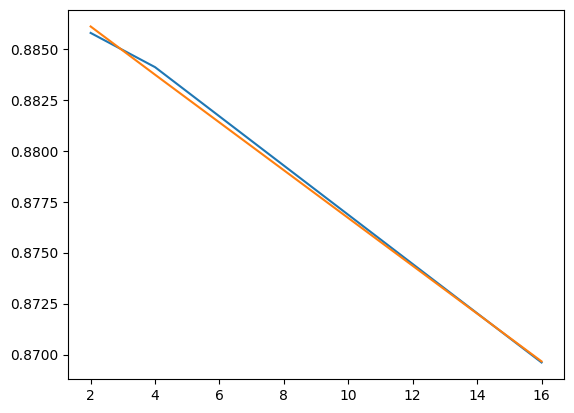

In [74]:
plt.plot(depths, expec)
plt.plot(depths, [expfit(x, *popt) for x in depths])

In [20]:
def random_circ(N):
    qc = QuantumCircuit(5)
    single_gates = [HGate(), SGate(), XGate(), ZGate()]
    insts = [q for q in backend.coupling_map.graph.edge_list()]
    for i in range(N):
            for i in range(5):
                if random() < .2:
                    qc.append(choice(single_gates), [i])
            if random() <= .4:
                inst = randint(0, len(insts)-1)
                q1,q2 = insts[inst]
                qc.cx(q1, q2)

    return transpile(qc, backend)